In [33]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pylab as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, DoubleType, StringType, LongType
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, from_unixtime
%matplotlib inline

Spark must load the JARs that contain the Pravega Hadoop Connector, Pravega Client, and UTF8StringSerializer.

In [2]:
conf = SparkConf()
conf.set("spark.jars", "/notebooks/work/iiotdemo-sparkprocessor-0.2.0-SNAPSHOT-all.jar")
conf.setMaster('local[2]')

In [23]:
sc = SparkContext.getOrCreate(conf=conf)
sql_sc = SQLContext(sc)

Create an RDD of strings from JSON events in a Pravega stream.

In [54]:
rdd = sc.newAPIHadoopRDD(
    inputFormatClass='io.pravega.connectors.hadoop.PravegaInputFormat',
    keyClass='io.pravega.connectors.hadoop.EventKey',
    valueClass='java.lang.String',
    conf={
        'pravega.scope': 'iot1',
        'pravega.stream': 'data',
        'pravega.uri': 'tcp://10.246.21.230:9090',
        'pravega.deserializer': 'io.pravega.example.iiotdemo.sparkprocessor.UTF8StringSerializer',
    },
)

In [62]:
rdd.keys().first()

{'__class__': 'io.pravega.connectors.hadoop.EventKey',
 'offset': 0,
 'segment': {'__class__': 'io.pravega.client.segment.impl.Segment',
  'scope': 'iot1',
  'scopedName': 'iot1/data/0',
  'scopedStreamName': 'iot1/data',
  'segmentNumber': 0,
  'stream': {'__class__': 'io.pravega.client.stream.impl.StreamImpl',
   'scope': 'iot1',
   'scopedName': 'iot1/data',
   'streamName': 'data'},
  'streamName': 'data'}}

In [60]:
sql_sc.read(rdd.keys())

TypeError: 'DataFrameReader' object is not callable

Read Pravega events without specifying a schema. This performs two passes on the data.

In [37]:
%%time
df = sql_sc.read.json(rdd.values())
df.show()

+---------+----------+-----------+------------------+-------------+------------------+-----------------+
|device_id|event_type|remote_addr|      temp_celsius|    timestamp|        vibration1|       vibration2|
+---------+----------+-----------+------------------+-------------+------------------+-----------------+
|     0002|      temp|  127.0.0.1|23.447554062011953|1526594516113|              null|             null|
|     0001|      temp|  127.0.0.1| 37.22421743210678|1526594516112|              null|             null|
|     0002| vibration|  127.0.0.1|              null|1526594516113|2965.9755406201193|6031.951081240239|
|     0001| vibration|  127.0.0.1|              null|1526594516112| 3103.742174321068|6307.484348642136|
|     0002|      temp|  127.0.0.1| 23.39155667180122|1526594517127|              null|             null|
|     0002| vibration|  127.0.0.1|              null|1526594517127|2965.4155667180116|6030.831133436023|
|     0001|      temp|  127.0.0.1| 37.14044473638414|15

View the generated schema.

In [38]:
df.schema

StructType(List(StructField(device_id,StringType,true),StructField(event_type,StringType,true),StructField(remote_addr,StringType,true),StructField(temp_celsius,DoubleType,true),StructField(timestamp,LongType,true),StructField(vibration1,DoubleType,true),StructField(vibration2,DoubleType,true)))

Read Pravega events with a schema. We also cache the result in memory.

In [39]:
%%time
schema = StructType([
        StructField('timestamp', LongType(), True),
        StructField('event_type', StringType(), True),
        StructField('device_id', StringType(), True),
        StructField('temp_celsius', DoubleType(), True),
        StructField('vibration1', DoubleType(), True),
        StructField('vibration2', DoubleType(), True),
    ])
df = sql_sc.read.schema(schema).json(rdd.values()).cache()
df.show()

+-------------+----------+---------+------------------+------------------+-----------------+
|    timestamp|event_type|device_id|      temp_celsius|        vibration1|       vibration2|
+-------------+----------+---------+------------------+------------------+-----------------+
|1526594516113|      temp|     0002|23.447554062011953|              null|             null|
|1526594516112|      temp|     0001| 37.22421743210678|              null|             null|
|1526594516113| vibration|     0002|              null|2965.9755406201193|6031.951081240239|
|1526594516112| vibration|     0001|              null| 3103.742174321068|6307.484348642136|
|1526594517127|      temp|     0002| 23.39155667180122|              null|             null|
|1526594517127| vibration|     0002|              null|2965.4155667180116|6030.831133436023|
|1526594517437|      temp|     0001| 37.14044473638414|              null|             null|
|1526594517437| vibration|     0001|              null|3102.9044473638

In [26]:
df.filter('event_type="temp"').show()

+-------------+----------+---------+------------------+----------+----------+
|    timestamp|event_type|device_id|      temp_celsius|vibration1|vibration2|
+-------------+----------+---------+------------------+----------+----------+
|1526594516113|      temp|     0002|23.447554062011953|      null|      null|
|1526594516112|      temp|     0001| 37.22421743210678|      null|      null|
|1526594517127|      temp|     0002| 23.39155667180122|      null|      null|
|1526594517437|      temp|     0001| 37.14044473638414|      null|      null|
|1526594518141|      temp|     0002|23.339366447471768|      null|      null|
|1526594518762|      temp|     0001| 37.07423386711112|      null|      null|
|1526594519155|      temp|     0002|23.290990950746018|      null|      null|
|1526594520087|      temp|     0001| 37.02570011068423|      null|      null|
|1526594520169|      temp|     0002|23.246437283613528|      null|      null|
|1526597031016|      temp|     0002| 70.98551354239365|      nul

In [40]:
df.count()

1525506

In [28]:
df = df.withColumn('timestamp_str', from_unixtime(df['timestamp'] / 1000.0))
df.show()

+-------------+----------+---------+------------------+------------------+-----------------+-------------------+
|    timestamp|event_type|device_id|      temp_celsius|        vibration1|       vibration2|      timestamp_str|
+-------------+----------+---------+------------------+------------------+-----------------+-------------------+
|1526594516113|      temp|     0002|23.447554062011953|              null|             null|2018-05-17 22:01:56|
|1526594516112|      temp|     0001| 37.22421743210678|              null|             null|2018-05-17 22:01:56|
|1526594516113| vibration|     0002|              null|2965.9755406201193|6031.951081240239|2018-05-17 22:01:56|
|1526594516112| vibration|     0001|              null| 3103.742174321068|6307.484348642136|2018-05-17 22:01:56|
|1526594517127|      temp|     0002| 23.39155667180122|              null|             null|2018-05-17 22:01:57|
|1526594517127| vibration|     0002|              null|2965.4155667180116|6030.831133436023|2018

In [29]:
df.sort('timestamp').show()

+-------------+----------+---------+------------------+------------------+-----------------+-------------------+
|    timestamp|event_type|device_id|      temp_celsius|        vibration1|       vibration2|      timestamp_str|
+-------------+----------+---------+------------------+------------------+-----------------+-------------------+
|1526594516112|      temp|     0001| 37.22421743210678|              null|             null|2018-05-17 22:01:56|
|1526594516112| vibration|     0001|              null| 3103.742174321068|6307.484348642136|2018-05-17 22:01:56|
|1526594516113|      temp|     0002|23.447554062011953|              null|             null|2018-05-17 22:01:56|
|1526594516113| vibration|     0002|              null|2965.9755406201193|6031.951081240239|2018-05-17 22:01:56|
|1526594517127|      temp|     0002| 23.39155667180122|              null|             null|2018-05-17 22:01:57|
|1526594517127| vibration|     0002|              null|2965.4155667180116|6030.831133436023|2018

In [41]:
sql_sc.registerDataFrameAsTable(df, 'rawData')

Run SQL queries.

In [42]:
sql_sc.sql('select * from rawData where event_type="vibration" order by vibration2 desc').show()

+-------------+----------+---------+------------+------------------+------------------+
|    timestamp|event_type|device_id|temp_celsius|        vibration1|        vibration2|
+-------------+----------+---------+------------+------------------+------------------+
|1526651598453| vibration|     0005|        null| 3644.857966779092| 7389.715933558184|
|1526646018623| vibration|     0005|        null|  3644.85796641069|  7389.71593282138|
|1526657178283| vibration|     0005|        null|3644.8579659159623|7389.7159318319245|
|1526640438793| vibration|     0005|        null|3644.8579648107557| 7389.715929621511|
|1526662758113| vibration|     0005|        null|3644.8579638209594| 7389.715927641919|
|1526634858963| vibration|     0005|        null| 3644.857961978856| 7389.715923957712|
|1526668337943| vibration|     0005|        null|3644.8579604946103| 7389.715920989221|
|1526629279133| vibration|     0005|        null| 3644.857957915703| 7389.715915831406|
|1526673917773| vibration|     0

In [44]:
%%time
sql_sc.sql("""
select device_id, event_type, count(*) as num_events, from_unixtime(max(timestamp)/1000) as last_timestamp
from rawData
group by device_id, event_type
""").show()

+---------+----------+----------+-------------------+
|device_id|event_type|num_events|     last_timestamp|
+---------+----------+----------+-------------------+
|     0003| vibration|     58719|2018-05-18 22:20:54|
|     0002| vibration|     93132|2018-05-18 22:20:55|
|     0006|      temp|     64170|2018-05-18 22:20:54|
|     0007|      temp|     77933|2018-05-18 22:20:54|
|     0010|      temp|     58557|2018-05-18 22:20:54|
|     0008| vibration|     61301|2018-05-18 22:20:54|
|     0001| vibration|     97064|2018-05-18 22:20:54|
|     0004|      temp|     61612|2018-05-18 22:20:54|
|     0003|      temp|     58719|2018-05-18 22:20:54|
|     0002|      temp|     93132|2018-05-18 22:20:55|
|     0004| vibration|     61612|2018-05-18 22:20:54|
|     0005|      temp|    108036|2018-05-18 22:20:54|
|     0007| vibration|     77933|2018-05-18 22:20:54|
|     0009| vibration|     82229|2018-05-18 22:20:54|
|     0010| vibration|     58557|2018-05-18 22:20:54|
|     0009|      temp|     8

In [46]:
sdf = sql_sc.sql('select * from rawData where event_type="vibration" order by vibration2 desc')

In [48]:
df = sdf.toPandas()
df.head()

,timestamp,event_type,device_id,temp_celsius,vibration1,vibration2
0,1526651598453,vibration,0005,None,3644.857967,7389.715934
1,1526646018623,vibration,0005,None,3644.857966,7389.715933
2,1526657178283,vibration,0005,None,3644.857966,7389.715932
3,1526640438793,vibration,0005,None,3644.857965,7389.715930
4,1526662758113,vibration,0005,None,3644.857964,7389.715928


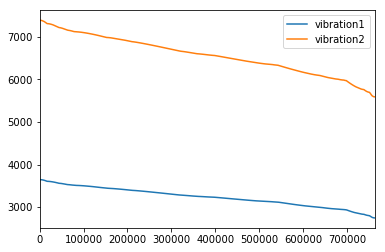

In [53]:
df[['vibration1','vibration2']].plot()